# Running HMETS using NRCAN forcing data

Here we use birdy's WPS client to launch the HMETS hydrological model on the server and analyze the output. We also prepare NRCAN daily data for Canadian catchments.

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import netCDF4 as nc
from zipfile import ZipFile
import glob


# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
#url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")

# THIS CHANGED TO REFLECT MASTER, NOT LATEST RELEASE!
url="http://localhost:9099" 

wps = WPSClient(url)

In [2]:
# DATA MAIN SOURCE
CANOPEX='https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ets/Watersheds_5797_cfcompliant.nc'


In [14]:
basindata=xr.open_dataset(CANOPEX)
watershedID=1500 # From 0 to 5796
basinName=basindata['watershed'][watershedID]
newBasin=basindata.isel(watershed=watershedID)
filepath = os.getcwd()+"/CANOPEX_subset.nc"
newBasin.to_netcdf(filepath)

In [18]:
# Raven is picky with the units formatting
import netCDF4 as nc
D = nc.Dataset(filepath, mode="a")
D.variables["time"].units += " 00:00:00"
D.close()

<xarray.DataArray 'pr' (time: 22280)>
array([2.773012e-05, 3.085206e-04, 7.230699e-04, ..., 1.469227e-05,
       6.290850e-06, 9.024374e-06])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2010-12-31
Attributes:
    long_name:              Precipitation
    standard_name:          precipitation_flux
    units:                  kg m-2 s-1
    coverage_content_type:  modelResult
    _ChunkSizes:            [ 363 1393]


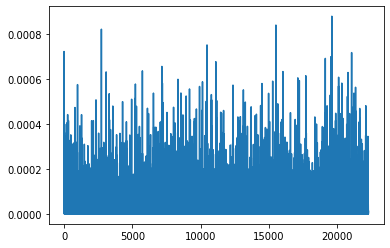

In [15]:
ds=xr.open_dataset(filepath)
basin_area=ds['drainage_area'].item(0)
print(ds['pr'])
plt.plot(ds['pr'])
plt.show()
ds.close()

In [16]:
# Dirty fix for testing only. We already have this info in the regionalization DB. Perhaps we can add it to the NetCDF?
# Else we can simply read from the csv.
basin_latitude = 50.0
basin_longitude = -75.0
basin_elevation = 350.0

In [19]:
# The model parameters. Can either be a string of comma separated values, a list, an array or a named tuple. 
params = '9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919, ' \
            '     2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'

# Model configuration parameters
config = dict(
    start_date=dt.datetime(1998, 5, 1),
    end_date=dt.datetime(2002, 6, 30),
    area=basin_area,
    elevation=basin_elevation,
    latitude=basin_latitude,
    longitude=basin_longitude,
    run_name='test_hmets_CANOPEX',
    rain_snow_fraction='RAINSNOW_DINGMAN',
    nc_spec=json.dumps({'tasmax': {'linear_transform': (1.0, -273.15)},'tasmin': {'linear_transform': (1.0, -273.15)},'pr': {'linear_transform': (86400.0, 0.0)}})  
)

# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.raven_hmets(ts=str(filepath), params=params, **config)


In [20]:

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [21]:
print(diagnostics)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH,/tmp/pywps_process_lyas_bt6/CANOPEX_subset.nc,-2.675,154.564,



The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [22]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 1522, nbasins: 1)>
array([[  0.      ],
       [199.582139],
       [395.909512],
       ...,
       [206.681151],
       [212.205446],
       [207.043272]])
Coordinates:
  * time        (time) datetime64[ns] 1998-05-01 1998-05-02 ... 2002-06-30
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

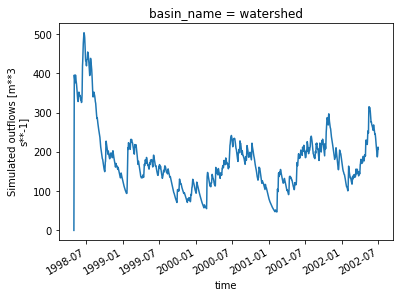

In [23]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [24]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby(hydrograph.time.dt.month).mean(dim='time'))

Max:  <xarray.DataArray 'q_sim' ()>
array(503.88831371)
Mean:  <xarray.DataArray 'q_sim' ()>
array(178.1896006)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[105.59213308],
       [132.72425951],
       [145.18835994],
       [149.66076662],
       [217.50481905],
       [241.34494684],
       [250.21438736],
       [217.71404516],
       [175.08495442],
       [184.41751911],
       [155.49077705],
       [134.48131373]])
Coordinates:
    basin_name  (nbasins) object ...
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins
